In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
from tqdm import tqdm

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.5.1+cu121
CUDA available: True


In [2]:
DATA_DIR = 'combined_data'

BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 0.0001
NUM_CLASSES = 5
IMG_SIZE = 224

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# No augmentation for validation/test
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("✓ Transforms defined")

✓ Transforms defined


In [4]:
# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), transform=val_transform)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Train samples: 41230
Val samples: 5101
Test samples: 5000
Classes: ['angry', 'happy', 'neutral', 'sad', 'surprised']


In [5]:
# Add dropout after loading model
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout
    nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
)
model = model.to(device)

print("✓ Model loaded and modified for 5 classes")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

c:\Users\Thy Panhasoth\Documents\AUPP\Sophomore - 2025\Fall 2025\ICT 361 - Intro to Robotics\object_detection\yolo\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Thy Panhasoth\Documents\AUPP\Sophomore - 2025\Fall 2025\ICT 361 - Intro to Robotics\object_detection\yolo\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ Model loaded and modified for 5 classes
Total parameters: 4,013,953


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

print("✓ Criterion, optimizer, and scheduler ready")

✓ Criterion, optimizer, and scheduler ready


In [7]:
def train_epoch(model, loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]', 
                leave=False, ncols=100)
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        current_acc = 100. * correct / total
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 
                         'acc': f'{current_acc:.2f}%'})
    
    accuracy = 100. * correct / total
    avg_loss = running_loss / len(loader)
    return avg_loss, accuracy

def validate(model, loader, criterion, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar for validation
    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Val]', 
                leave=False, ncols=100)
    
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            current_acc = 100. * correct / total
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 
                             'acc': f'{current_acc:.2f}%'})
    
    accuracy = 100. * correct / total
    avg_loss = running_loss / len(loader)
    return avg_loss, accuracy

print("✓ Training functions with progress bars defined")

✓ Training functions with progress bars defined


In [8]:
# Initialize history dictionary
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

print("Starting training...\n")
print("="*70)

for epoch in range(EPOCHS):
    # Train with progress bar
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch)
    
    # Validate with progress bar
    val_loss, val_acc = validate(model, val_loader, criterion, epoch)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"  Train → Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"  Val   → Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_b0.pth')
        print(f"  ✓ Best model saved! (Val Acc: {val_acc:.2f}%)")
    
    scheduler.step(val_acc)
    print("-"*70)

print("\n" + "="*70)
print(f"Training complete! Best validation accuracy: {best_val_acc:.2f}%")
print("="*70)

Starting training...




Epoch 1/20
  Train → Loss: 1.0861, Acc: 55.20%
  Val   → Loss: 0.8422, Acc: 67.08%
  ✓ Best model saved! (Val Acc: 67.08%)
----------------------------------------------------------------------



Epoch 2/20
  Train → Loss: 0.7915, Acc: 69.36%
  Val   → Loss: 0.7647, Acc: 71.75%
  ✓ Best model saved! (Val Acc: 71.75%)
----------------------------------------------------------------------



Epoch 3/20
  Train → Loss: 0.6911, Acc: 73.58%
  Val   → Loss: 0.7098, Acc: 73.77%
  ✓ Best model saved! (Val Acc: 73.77%)
----------------------------------------------------------------------



Epoch 4/20
  Train → Loss: 0.6230, Acc: 76.34%
  Val   → Loss: 0.7137, Acc: 74.20%
  ✓ Best model saved! (Val Acc: 74.20%)
----------------------------------------------------------------------



Epoch 5/20
  Train → Loss: 0.5618, Acc: 78.53%
  Val   → Loss: 0.7240, Acc: 75.04%
  ✓ Best model saved! (Val Acc: 75.04%)
----------------------------------------------------------------------



Epoch 6/20
  Train → Loss: 0.5075, Acc: 80.80%
  Val   → Loss: 0.7269, Acc: 75.55%
  ✓ Best model saved! (Val Acc: 75.55%)
----------------------------------------------------------------------



Epoch 7/20
  Train → Loss: 0.4612, Acc: 82.53%
  Val   → Loss: 0.7449, Acc: 75.24%
----------------------------------------------------------------------



Epoch 8/20
  Train → Loss: 0.4158, Acc: 84.36%
  Val   → Loss: 0.8203, Acc: 74.89%
----------------------------------------------------------------------



Epoch 9/20
  Train → Loss: 0.3762, Acc: 85.91%
  Val   → Loss: 0.8275, Acc: 74.69%
----------------------------------------------------------------------



Epoch 10/20
  Train → Loss: 0.3458, Acc: 87.19%
  Val   → Loss: 0.8679, Acc: 74.93%
----------------------------------------------------------------------



Epoch 11/20
  Train → Loss: 0.2651, Acc: 90.27%
  Val   → Loss: 0.9227, Acc: 74.77%
----------------------------------------------------------------------



Epoch 12/20
  Train → Loss: 0.2367, Acc: 91.36%
  Val   → Loss: 0.9613, Acc: 75.85%
  ✓ Best model saved! (Val Acc: 75.85%)
----------------------------------------------------------------------



Epoch 13/20
  Train → Loss: 0.2195, Acc: 92.01%
  Val   → Loss: 1.0068, Acc: 75.46%
----------------------------------------------------------------------



Epoch 14/20
  Train → Loss: 0.2050, Acc: 92.46%
  Val   → Loss: 1.0191, Acc: 75.36%
----------------------------------------------------------------------



Epoch 15/20
  Train → Loss: 0.1842, Acc: 93.41%
  Val   → Loss: 1.0585, Acc: 74.77%
----------------------------------------------------------------------



Epoch 16/20
  Train → Loss: 0.1798, Acc: 93.54%
  Val   → Loss: 1.0875, Acc: 75.73%
----------------------------------------------------------------------



Epoch 17/20
  Train → Loss: 0.1465, Acc: 94.86%
  Val   → Loss: 1.1045, Acc: 75.38%
----------------------------------------------------------------------



Epoch 18/20
  Train → Loss: 0.1296, Acc: 95.54%
  Val   → Loss: 1.1555, Acc: 75.71%
----------------------------------------------------------------------



Epoch 19/20
  Train → Loss: 0.1315, Acc: 95.32%
  Val   → Loss: 1.1418, Acc: 76.06%
  ✓ Best model saved! (Val Acc: 76.06%)
----------------------------------------------------------------------



Epoch 20/20
  Train → Loss: 0.1213, Acc: 95.62%
  Val   → Loss: 1.1480, Acc: 75.93%
----------------------------------------------------------------------

Training complete! Best validation accuracy: 76.06%


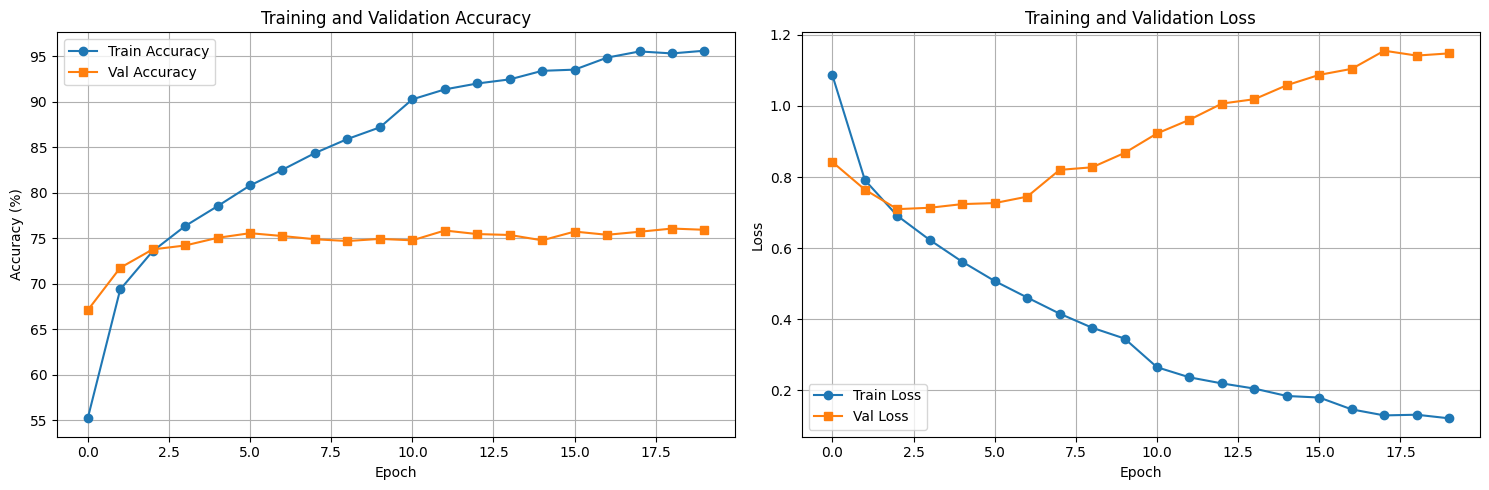

Best Validation Accuracy: 76.06%
Final Training Accuracy: 95.62%
Final Validation Accuracy: 75.93%


In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history['train_acc'], label='Train Accuracy', marker='o')
ax1.plot(history['val_acc'], label='Val Accuracy', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Training and Validation Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(history['train_loss'], label='Train Loss', marker='o')
ax2.plot(history['val_loss'], label='Val Loss', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Best Validation Accuracy: {max(history['val_acc']):.2f}%")
print(f"Final Training Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")

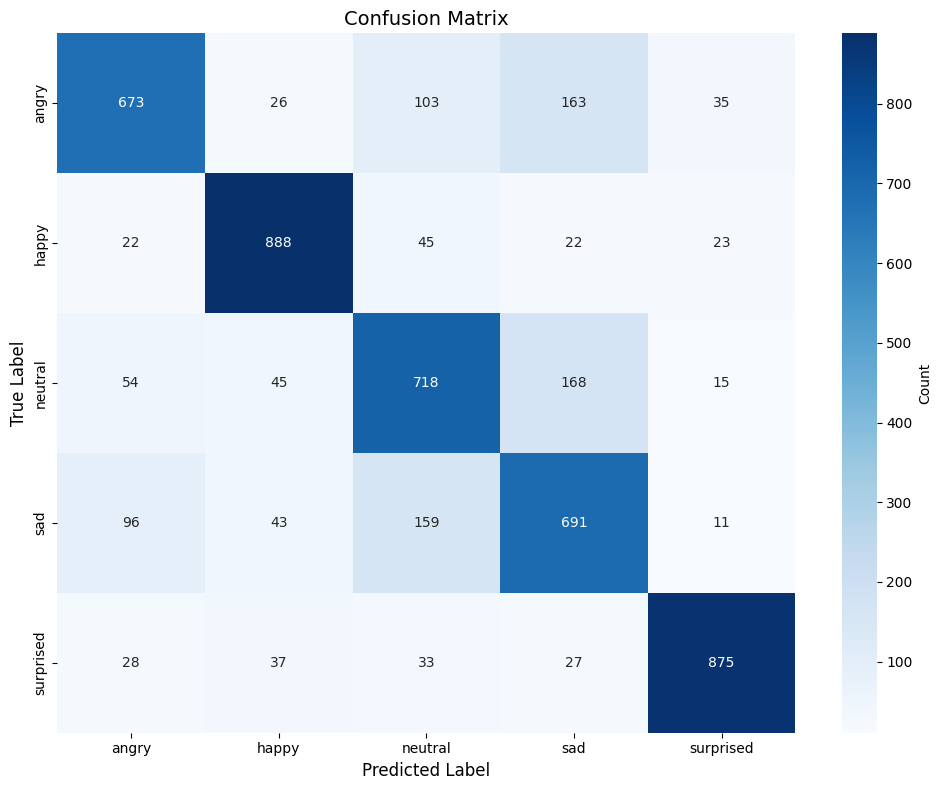


Classification Report:
              precision    recall  f1-score   support

       angry       0.77      0.67      0.72      1000
       happy       0.85      0.89      0.87      1000
     neutral       0.68      0.72      0.70      1000
         sad       0.65      0.69      0.67      1000
   surprised       0.91      0.88      0.89      1000

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000


Per-Class Accuracy:
     angry: 67.30% (673/1000)
     happy: 88.80% (888/1000)
   neutral: 71.80% (718/1000)
       sad: 69.10% (691/1000)
 surprised: 87.50% (875/1000)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get predictions on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Get class names
class_names = train_dataset.classes

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print("="*60)
print(classification_report(all_labels, all_preds, target_names=class_names))

# Calculate per-class accuracy
print("\nPer-Class Accuracy:")
print("="*60)
for i, class_name in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i].sum()
    class_acc = 100.0 * class_correct / class_total
    print(f"{class_name:>10s}: {class_acc:.2f}% ({class_correct}/{class_total})")